In [15]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import product
from dataclasses import dataclass
import os
import math
import sys
from typing import Dict, Any, List, Optional
sys.path.append('../../../../')

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter

from multitask_nlp.utils.plotting import Task, get_overall_score, visualize_boxplot, plot_gain_matrix

color_pallette = 'muted'
sns.set_theme(style='whitegrid', context='talk', palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

tasks = [
    Task(name='BoolQ', measure='macro_f1_label', 
         measure_name='Macro F1', size=6927),
    Task(name='CommitmentBank', short_name='CB', measure='macro_f1_label', 
         measure_name='Macro F1', size=200),
    Task(name='Conll2003', measure='micro_f1_ner_tags', 
         measure_name='Micro F1', size=14724),
    Task(name='GoEmotions', short_name='GoEmo', measure='macro_f1_mean', 
         measure_name='Macro F1', size=34806),
    Task(name='MeasuringHateSpeech', short_name='MHS', measure='r2_hate_speech_score', 
         measure_name='R2', size=23739),
    Task(name='Multiemo', measure='macro_f1_sentiment', 
         measure_name='Macro F1', size=6572),
    Task(name='MultiRC', measure='macro_f1_label', 
         measure_name='Macro F1', size=22275),
    Task(name='Pejorative', measure='macro_f1_is_pejorative', 
         measure_name='Macro F1', size=638),
    Task(name='RTE', measure='macro_f1_label', 
         measure_name='Macro F1', size=2190),
    Task(name='SciTail', measure='macro_f1_label', 
         measure_name='Macro F1', size=23097),
    Task(name='SST-2', measure='macro_f1_label', 
         measure_name='Macro F1', size=66449),
    Task(name='STS-B', measure='r2_label', 
         measure_name='R2', size=4249)  
]

cols_to_display = ['dataset', 'learning_kind', 'model_name', 'model_type',
       'mt_dataset_type',  'scale_class_loss', 'uncertainty_loss', 'type', 'overall_score', 'weighted_overall_score']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
for task in tasks:
    print(task.name, end='')
    if task.short_name is not None:
        print(f' ({task.short_name}), ', end='')
    else:
        print(', ', end='')

BoolQ, CommitmentBank (CB), Conll2003, GoEmotions (GoEmo), MeasuringHateSpeech (MHS), Multiemo, MultiRC, Pejorative, RTE, SciTail, SST-2, STS-B, 

In [3]:
def get_type(row):
    ttype = row['learning_kind']
    if not pd.isna(row['mt_dataset_type']):
        ttype += '_' + str(row['mt_dataset_type'])
        if row['mt_dataset_type'] == 'proportional_sampling':
            ttype += r'_$\alpha={}$'.format(row['alpha'])
        
    return ttype

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['uncertainty_loss'] = df['uncertainty_loss'].fillna(False)
    df['type'] = df.apply(lambda x: get_type(x), axis=1)
    df['overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks), axis=1)
    df['weighted_overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks, weighted=True), axis=1)
    
    for scale_class_loss, uncertainty_loss, model_name in product(
            df['scale_class_loss'].unique(), df['uncertainty_loss'].unique(), df['model_name'].unique()):
        curr_df = df[(df['learning_kind'] == 'STL') & 
                     (df['scale_class_loss'] == scale_class_loss) &
                     (df['uncertainty_loss'] == uncertainty_loss) &
                     (df['model_name'] == model_name)]

        if len(curr_df) > 0:   
            stl_results = {}
            for task_name in curr_df.dataset.unique():
                for task in tasks:
                    if task_name == task.name:
                        col_measure = f'{task.name}_test_{task.measure}'
                        stl_results[task.name] = curr_df[curr_df.dataset == task.name][col_measure].values, task.size

            total_size = sum([task.size for task in tasks])
            overall_results = sum([v[0] for v in stl_results.values()]) / len(tasks)
            weighted_overall_results = sum([v[1]*v[0] for v in stl_results.values()]) / total_size

            records = [
                {'learning_kind': 'STL',
                 'type': 'STL', 
                 'scale_class_loss': scale_class_loss, 
                 'uncertainty_loss': uncertainty_loss,
                 'model_name': model_name,
                 'overall_score': r1, 
                 'weighted_overall_score': r2}
                for r1, r2 in zip(overall_results, weighted_overall_results)
            ]
            df = pd.concat([df, pd.DataFrame(records)], ignore_index=True) 

    return df

In [6]:
def get_model_kind(r):
    kind = r['model_name']
    if r['scale_class_loss'] not in (None, 'none'):
        kind += ' ' + r['scale_class_loss']
    if r['uncertainty_loss'] is True:
        kind += ' UW'
        
    return kind

In [7]:
df = load_results_df('mtl_bert_vs_distilbert_results.csv')
df['model_kind'] = df.apply(lambda r: get_model_kind(r), axis=1)

In [7]:
# df.value_counts(["type", "model_kind", "scale_class_loss"])

In [8]:
# df[['batch_size', 'learning_rate', 'max_length', 'model_name', 'model_type', 'mt_dataset_type', 
#     'num_epochs', 'scale_class_loss', 'warmup_proportion', 'weight_decay', 'alpha', 'steps']].drop_duplicates()

In [9]:
# with pd.option_context('display.max_rows', None):
#     display(df[cols_to_display + ['model_kind']])

In [10]:
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'BoolQ_test_macro_f1_label', 'overall_score']])

In [11]:
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'scale_class_loss', 'epoch', 'num_epochs', 'trainer/global_step', 'Runtime']])

In [12]:
# df.columns.values

In [9]:
df['model_kind'].unique()

array(['bert UW', 'distilbert UW', 'bert log', 'bert linear', 'bert',
       'distilbert log', 'distilbert linear', 'distilbert'], dtype=object)

In [10]:
df['model_kind'].value_counts()

bert log             95
bert linear          95
bert                 95
distilbert log       95
distilbert linear    95
distilbert           95
bert UW               5
distilbert UW         5
Name: model_kind, dtype: int64

In [11]:
df['type'].unique()

array(['MTL_round_robin', 'MTL_dynamic_temperature_sampling',
       'MTL_proportional_sampling_$\\alpha=0.2$',
       'MTL_annealing_sampling',
       'MTL_proportional_sampling_$\\alpha=0.75$', 'MTL_sampling', 'STL'],
      dtype=object)

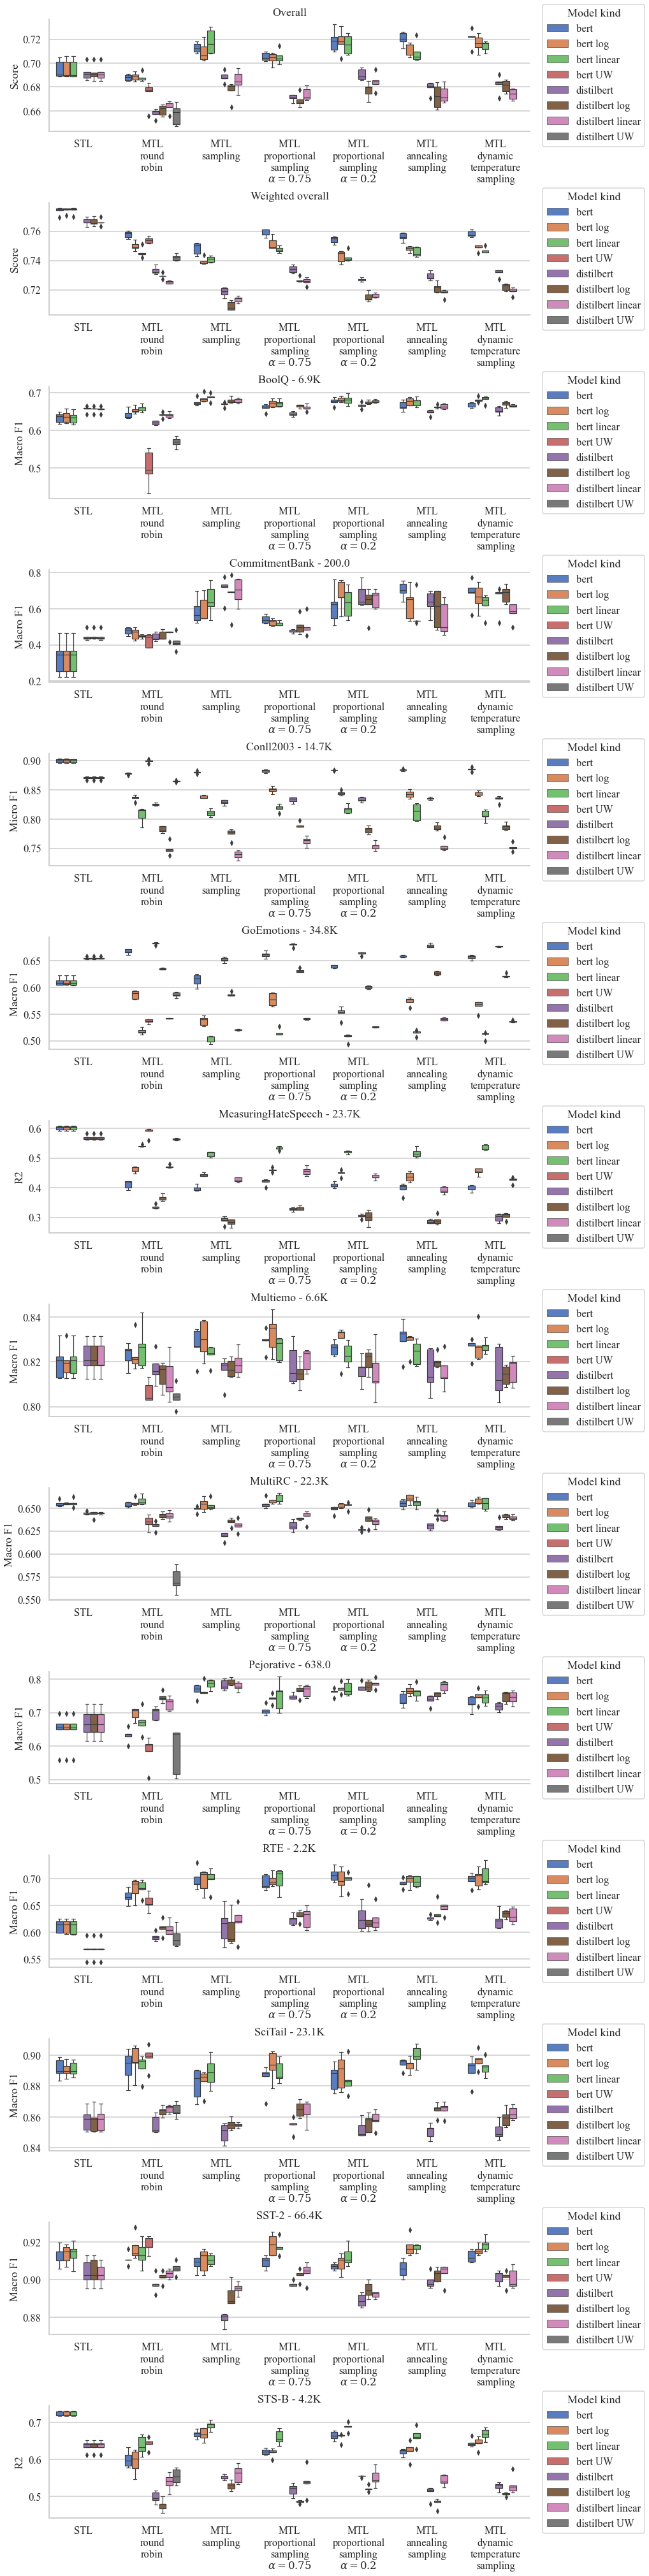

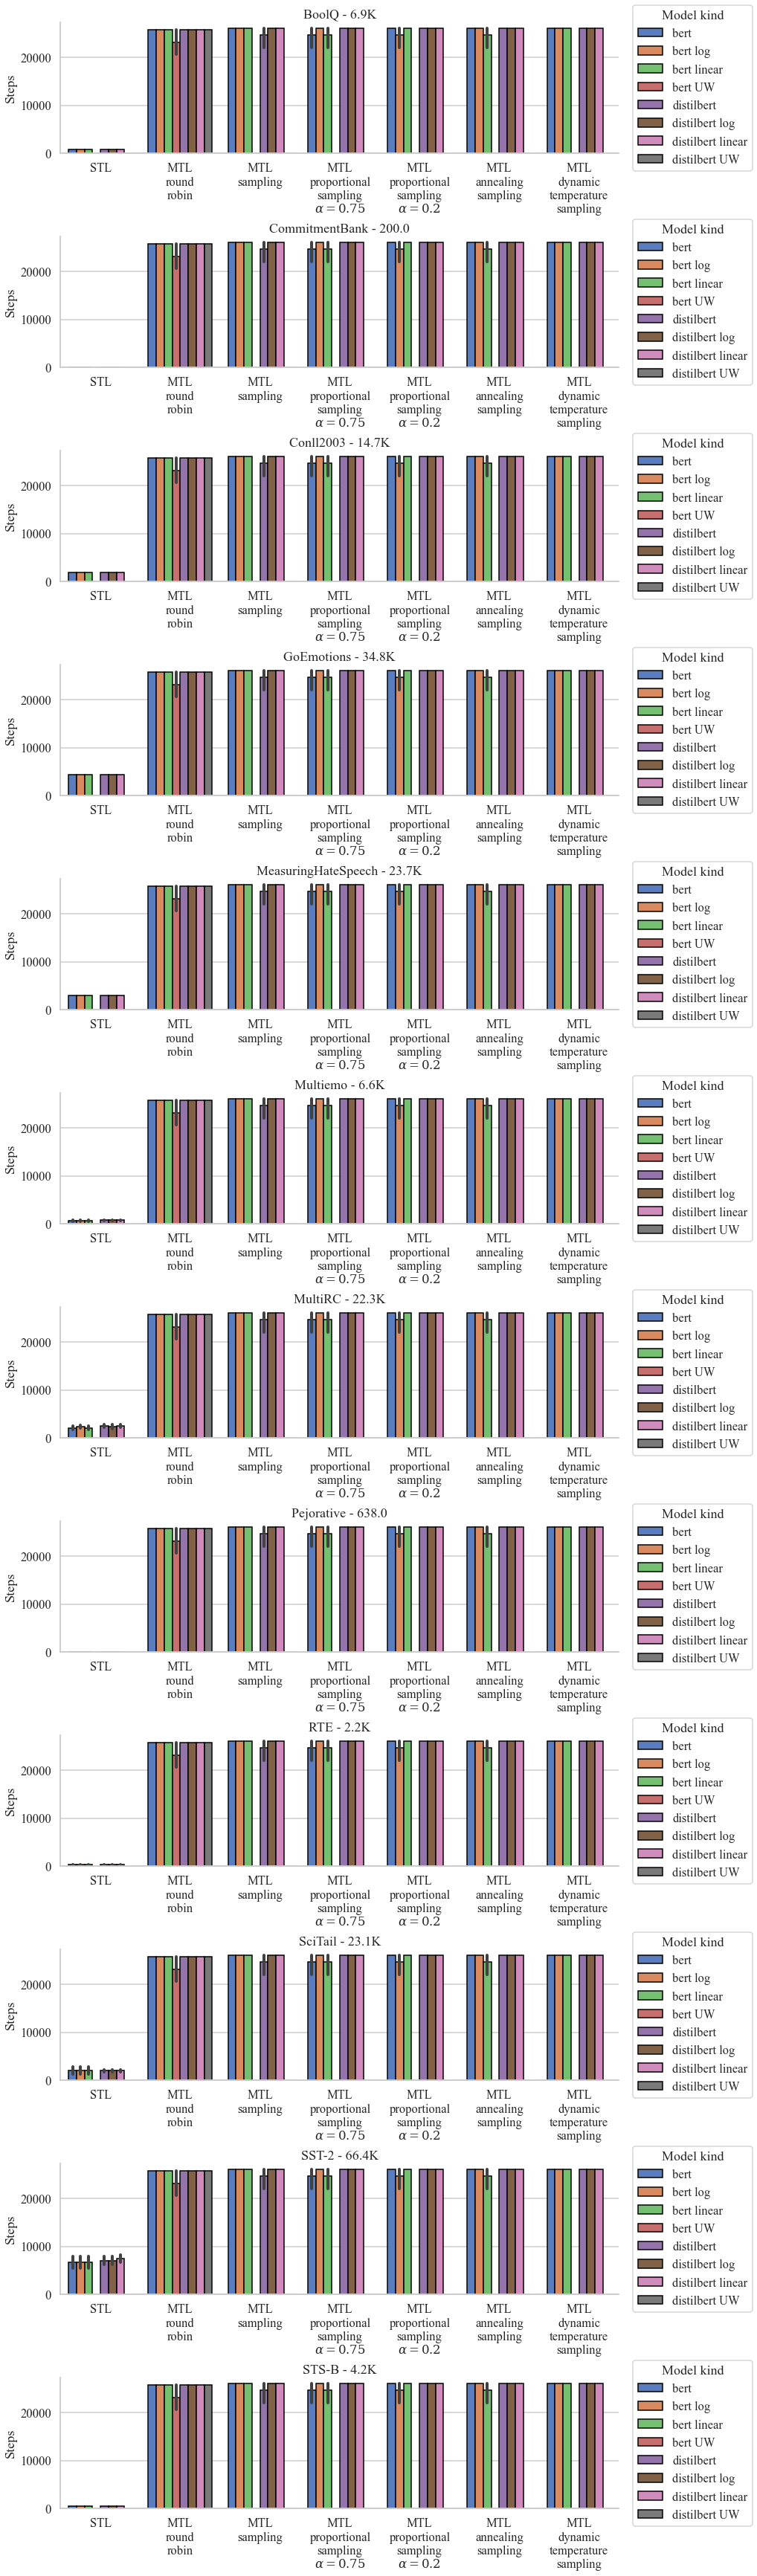

In [12]:
order = ['STL', 'MTL_round_robin', 'MTL_sampling', 'MTL_proportional_sampling_$\\alpha=0.75$', 
         'MTL_proportional_sampling_$\\alpha=0.2$', 'MTL_annealing_sampling', 'MTL_dynamic_temperature_sampling']

hue_order = ['bert',  'bert log', 'bert linear', 'bert UW',
             'distilbert', 'distilbert log', 'distilbert linear', 'distilbert UW']

visualize_boxplot(
    df, tasks=tasks,
    cols=1, row_height=4, fig_width=14, all_tasks=True,
    savefig=False, filename='mtl_bert_vs_distilbert_results_plot',
    showfliers=True, linewidth=1.2, order=order, 
    hue='model_kind', 
    hue_order=hue_order,
    ncol=1, loc='center right', bbox_to_anchor=(1.25, 0.5), only_fig_legend=False,
    runtimes=False, steps=True, 
)

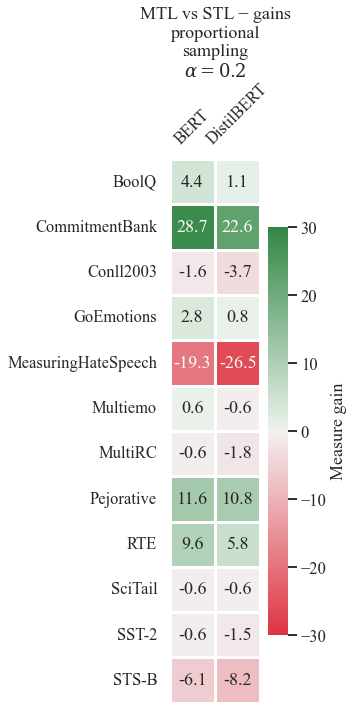

In [22]:
mtl_types = ['MTL_round_robin', 'MTL_proportional_sampling_$\\alpha=0.2$', 'MTL_dynamic_temperature_sampling']
mtl_types = ['MTL_proportional_sampling_$\\alpha=0.2$']
plot_gain_matrix(df, mtl_types=mtl_types, tasks=tasks, v_bound=30,
                 savefig=False, filename='mtl_bert_vs_distilbert_gains')